https://github.com/wwrechard/pydlm

https://pydlm.github.io/

http://ftp.stat.duke.edu/WorkingPapers/11-19.pdf

Dynamic Linear Models (DLMs) or state space models define a very general class of non-stationary time series
models. DLMs may include terms to model trends, seasonality, covariates and autoregressive components. The main goals are short-term forecasting, intervention
analysis and monitoring.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pydlm.plot.dlmPlot as dlmPlot
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason, modelTuner
from pydlm import dynamic

This package implementes the Bayesian dynamic linear model (Harrison and West, 1999) for time series data analysis. Modeling and fitting is simple and easy with pydlm. Complex models can be constructed via simple operations:

In [2]:
data = [0] * 100 + [3] * 100
# construct the base
myDLM = dlm(data)
# adding model components
# add a first-order trend (linear trending) with prior covariance 1.0
myDLM = myDLM + trend(1, name='lineTrend', w=1.0)
# add a 7 day seasonality with prior covariance 1.0
myDLM = myDLM + seasonality(7, name='7day', w=1.0)
# add a 3 step auto regression
myDLM = myDLM + autoReg(degree=3, data=data, name='ar3', w=1.0)
# show the added components
myDLM.ls()
# delete unwanted component
myDLM.delete('7day')
myDLM.ls()

The static components are
lineTrend (degree = 2)
7day (degree = 7)
 
There is no dynamic component.
 
The automatic components are
ar3 (dimension = 3)
The static components are
lineTrend (degree = 2)
 
There is no dynamic component.
 
The automatic components are
ar3 (dimension = 3)


Users can then analyze the data with the constructed model:

In [3]:
# fit forward filter
myDLM.fitForwardFilter()
# fit backward smoother
myDLM.fitBackwardSmoother()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


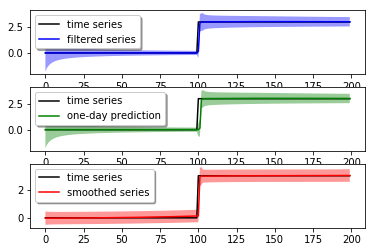

In [4]:
# plot the results
myDLM.plot()

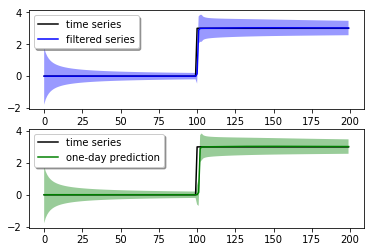

In [5]:
# plot only the filtered results
myDLM.turnOff('smoothed plot')
myDLM.plot()

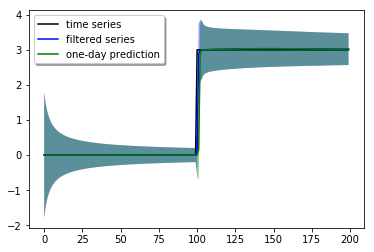

In [6]:
# plot in one figure
myDLM.turnOff('multiple plots')
myDLM.plot()

User can also plot the mean of a component (the time series value that attributed to this component):

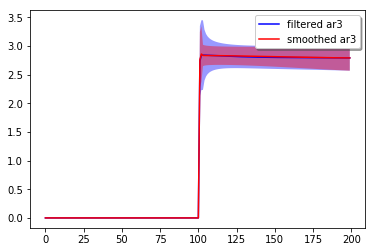

In [7]:
# plot the component mean of 'ar3'
myDLM.turnOn('smoothed plot')
myDLM.turnOff('predict')
myDLM.plot(name='ar3')

and also the latent states for a given component:

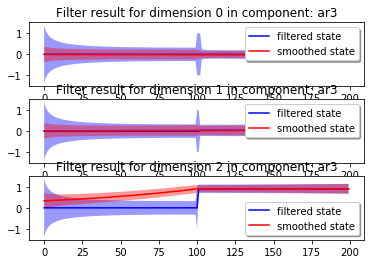

In [8]:
# plot the latent states of the 'ar3'
myDLM.plotCoef(name='ar3')

It also includes the discounting factor, which can be used to control how rapidly the model should adapt to the new data:

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


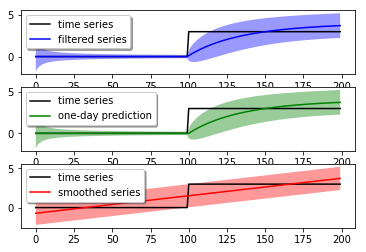

In [9]:
data = [0] * 100 + [3] * 100
myDLM = dlm(data) + trend(1, discount=1.0, w=1.0)
myDLM.fit()
myDLM.plot()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


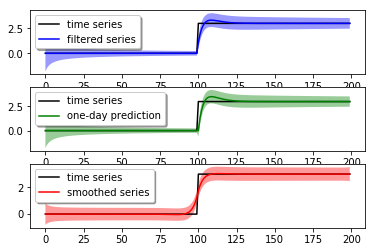

In [10]:
myDLM.delete('trend')
myDLM = myDLM + trend(1, discount=0.8, w=1.0)
myDLM.fit()
myDLM.plot()

The discounting factor can be auto-tuned by the modelTuner provided by the package:

In [11]:
myTuner = modelTuner(method='gradient_descent', loss='mse')
tunedDLM = myTuner.tune(myDLM, maxit=100)

The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.


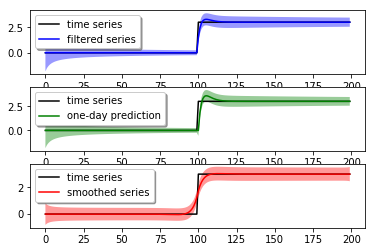

In [12]:
tunedDLM.fit()
tunedDLM.plot()

## Real data example

https://pydlm.github.io/example1.html

In [13]:
ls

data.csv                       pydlm example 17-2-2018.ipynb
main.py


In [14]:
data_file = open("data.csv", 'r')

Plot the raw data, which is the weekly counts of initial claims for unemployment during 2004 - 2012. We can see strong annual pattern and some local trend from the data. 

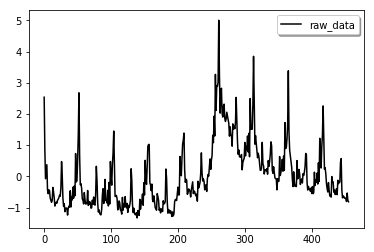

In [15]:
variables = data_file.readline().strip().split(',')
data_map = {}
for var in variables:
    data_map[var] = []

for line in data_file:
    for i, data_piece in enumerate(line.strip().split(',')):
        data_map[variables[i]].append(float(data_piece))

# Extract and store the data.
time_series = data_map[variables[0]]
features = [[data_map[variables[j]][i] for j in range(1, len(variables)) ]
            for i in range(len(time_series))]

# Plot the raw data

dlmPlot.plotData(range(len(time_series)),
                 time_series,
                 showDataPoint=False,
                 label='raw_data')
plt.legend(loc='best', shadow=True)
plt.show()

we first build a simple model with only local linear trend and seasonality component:

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


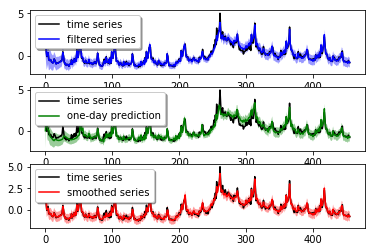

In [16]:
# Build a simple model

# A linear trend
linear_trend = trend(degree=1, discount=0.95, name='linear_trend', w=10)
# A seasonality
seasonal52 = seasonality(period=52, discount=0.99, name='seasonal52', w=10)

simple_dlm = dlm(time_series) + linear_trend + seasonal52
simple_dlm.fit()

# Plot the fitted results
simple_dlm.turnOff('data points')
simple_dlm.plot()
# Plot each com

The blue curve is the forward filtering result, the green curve is the one-day ahead prediction and the red curve is the backward smoothed result. The light-colored ribbon around the curve is the confidence interval (you might need to zoom-in to see it). The one-day ahead prediction shows this simple model captures the time series somewhat good but loses accuracy around the peak crisis at Week 280 (which is between year 2008 - 2009). The one-day-ahead mean squared prediction error is 0.173 which can be obtaied by calling:

We can decompose the time series into each of its components:

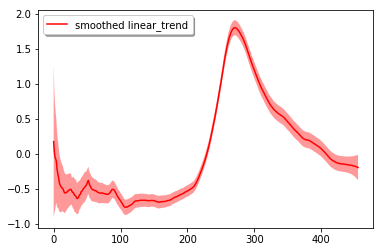

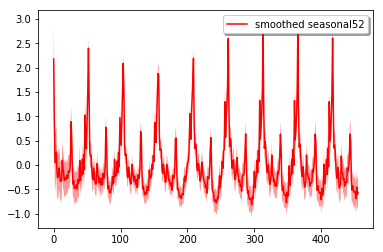

In [17]:
# Plot each component (attribution)
simple_dlm.turnOff('predict plot')
simple_dlm.turnOff('filtered plot')
simple_dlm.plot('linear_trend')
simple_dlm.plot('seasonal52')

Most of the time series shape is attributed to the local linear trend and the strong seasonality pattern is easily seen. To further verify the performance, we use this simple model for long-term forecasting. In particular, we use the previous 351 week ‘s data to forecast the next 200 weeks and the previous 251 week ‘s data to forecast the next 200 weeks. We lay the predicted results on top of the real data:

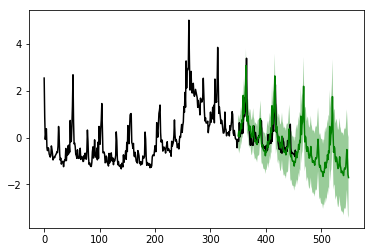

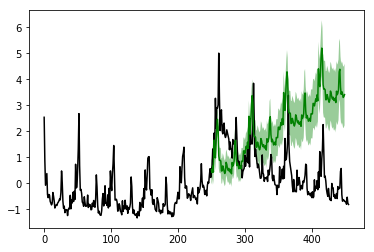

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


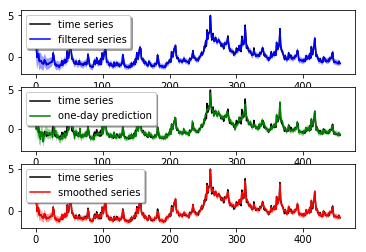

In [18]:
# Plot the prediction give the first 350 weeks and forcast the next 200 weeks.
simple_dlm.plotPredictN(N=200, date=350)
# Plot the prediction give the first 250 weeks and forcast the next 200 weeks.
simple_dlm.plotPredictN(N=200, date=250)

# Build a dynamic regression model
regressor10 = dynamic(features=features, discount=1.0, name='regressor10', w=10)
drm = dlm(time_series) + linear_trend + seasonal52 + regressor10
drm.fit()

# Plot the fitted results
drm.turnOff('data points')
drm.plot()

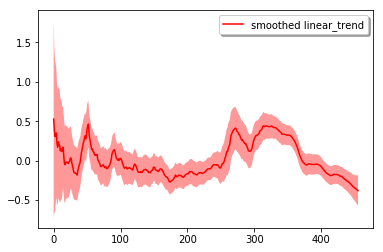

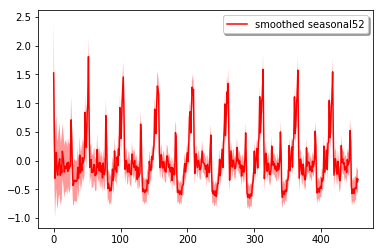

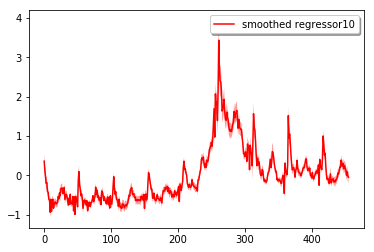

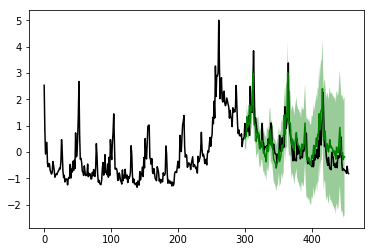

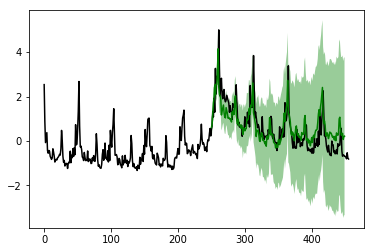

In [19]:
# Plot each component (attribution)
drm.turnOff('predict plot')
drm.turnOff('filtered plot')
drm.plot('linear_trend')
drm.plot('seasonal52')
drm.plot('regressor10')
# Plot the prediction give the first 300 weeks and forcast the next 150 weeks.
drm.plotPredictN(N=150, date=300)
# Plot the prediction give the first 250 weeks and forcast the next 200 weeks.
drm.plotPredictN(N=200, date=250)